[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/16jWa4TCTHyhikrfL29Xj-ukH8BCQRGbx?authuser=3#scrollTo=7nWxG_rxFE55
)


   Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0       3040     244     33                             213.4   
1       2637     242     37                             124.2   
2       2035      52     33                            -111.0   
3       2425     198     24                             137.5   
4       2364     301     36                              14.3   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Fire_Points  \
0                           -38.5                              1453.8   
1                           -94.5                               668.1   
2                            10.9                                80.9   
3                            66.6                               -14.6   
4                           -25.1                              -409.5   

   Horizontal_Distance_To_Roadways  Hillshade_9am  Hillshade_Noon  \
0                           1281.3            182             178   
1                            767

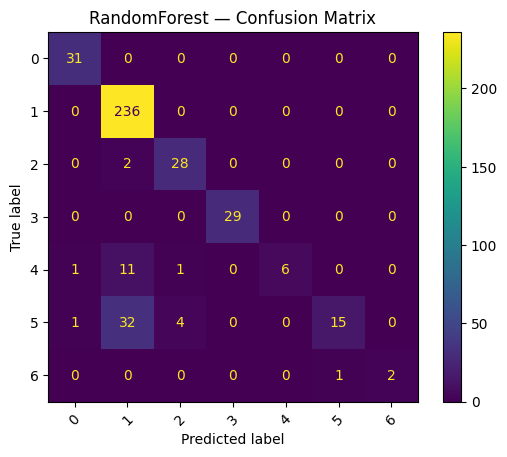

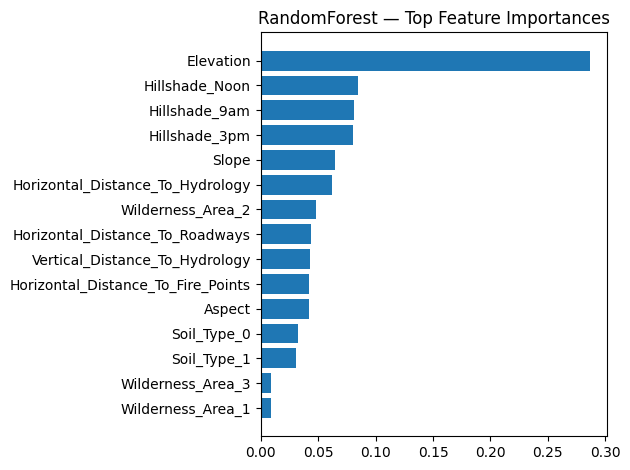


XGBoost accuracy: 0.95
              precision    recall  f1-score   support

           1       0.94      1.00      0.97        31
           2       0.94      1.00      0.97       236
           3       0.97      0.97      0.97        30
           4       1.00      1.00      1.00        29
           5       0.94      0.79      0.86        19
           6       0.95      0.77      0.85        52
           7       1.00      0.33      0.50         3

    accuracy                           0.95       400
   macro avg       0.96      0.84      0.87       400
weighted avg       0.95      0.95      0.95       400



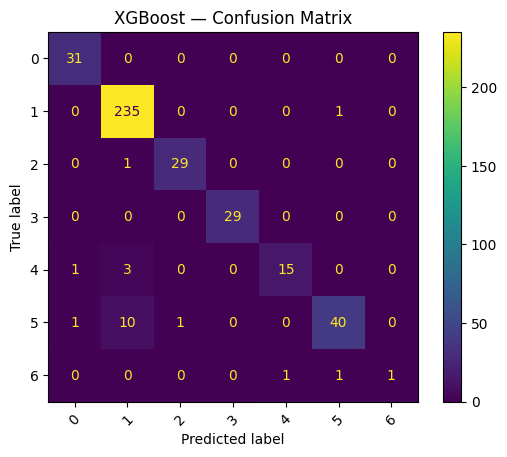


Best RF params: {'clf__max_depth': 20, 'clf__max_features': 'sqrt', 'clf__n_estimators': 200}
Best CV accuracy: 0.8587448147601614
Tuned RF test accuracy: 0.865


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
)
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# -------- 0) Load data (GitHub raw URL or manual upload) --------
USE_GITHUB = True  # <- set to True so it uses the GitHub link
GITHUB_CSV_URL = "https://raw.githubusercontent.com/zoyarattani/Elevvo-Pathways-Machine-Learning-Internship-Tasks/refs/heads/main/covertype_synthetic.csv"

if USE_GITHUB:
    df = pd.read_csv(GITHUB_CSV_URL)
else:
    from google.colab import files
    uploaded = files.upload()  # pick covertype_synthetic.csv
    df = pd.read_csv("covertype_synthetic.csv")

print(df.head())
print(df.shape, "\nClass counts:\n", df['Cover_Type'].value_counts().sort_index())

# -------- 1) Features / target --------
target = "Cover_Type"
X = df.drop(columns=[target]).copy()
y = df[target].copy()

# Treat integer-coded categoricals as categorical
cat_cols = []
for col in ["Wilderness_Area", "Soil_Type"]:
    if col in X.columns:
        X[col] = X[col].astype("category")
        cat_cols.append(col)

num_cols = [c for c in X.columns if c not in cat_cols]

# Preprocess: one-hot encode categoricals; leave numeric as-is (tree models don't need scaling)
preprocess = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)],
    remainder="passthrough"
)

# Train/test split (stratify to keep class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -------- 2) Model A: RandomForest --------
rf = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=300, max_depth=None, n_jobs=-1, random_state=42
    ))
])

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("\nRandomForest accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_rf)).plot(xticks_rotation=45)
plt.title("RandomForest — Confusion Matrix")
plt.show()

# Feature importances (map back to names)
rf_model = rf.named_steps["clf"]
ohe = rf.named_steps["prep"].named_transformers_.get("cat", None)
cat_feature_names = ohe.get_feature_names_out(cat_cols).tolist() if (ohe and cat_cols) else []
feature_names = cat_feature_names + num_cols
importances = rf_model.feature_importances_

# Plot top 15
top = np.argsort(importances)[-15:]
plt.barh(np.array(feature_names)[top], importances[top])
plt.title("RandomForest — Top Feature Importances")
plt.tight_layout()
plt.show()

# -------- 3) Model B: XGBoost (fix labels to start at 0) --------
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)  # classes e.g., [1..7] -> [0..6]
y_test_enc  = le.transform(y_test)

xgb = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", XGBClassifier(
        n_estimators=300, max_depth=6, learning_rate=0.1,
        subsample=0.9, colsample_bytree=0.9,
        objective="multi:softprob", num_class=len(le.classes_),
        eval_metric="mlogloss", random_state=42, tree_method="hist"
    ))
])

xgb.fit(X_train, y_train_enc)
y_pred_xgb_enc = xgb.predict(X_test)
y_pred_xgb = le.inverse_transform(y_pred_xgb_enc)

print("\nXGBoost accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_xgb)).plot(xticks_rotation=45)
plt.title("XGBoost — Confusion Matrix")
plt.show()

# -------- 4) Bonus: quick RF hyperparameter tuning (small grid) --------
param_grid = {
    "clf__n_estimators": [200, 400],
    "clf__max_depth": [None, 12, 20],
    "clf__max_features": ["sqrt", "log2"]
}
rf_grid = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", RandomForestClassifier(random_state=42, n_jobs=-1))
])

grid = GridSearchCV(rf_grid, param_grid, cv=3, scoring="accuracy", n_jobs=-1)
grid.fit(X_train, y_train)
print("\nBest RF params:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)
y_pred_best = grid.best_estimator_.predict(X_test)
print("Tuned RF test accuracy:", accuracy_score(y_test, y_pred_best))

